## Setting Up

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge

from model_funcs import *

%matplotlib inline

In [2]:
data = pd.read_csv('files/cleaned_data.csv')
X_train, X_test, y_train, y_test = data_split(data)

In [3]:
with open('files/saved_models.json') as json_file:
    saved_models = json.load(json_file)
saved_models

{'rf': 'RandomForestRegressor(random_state = 42, max_depth=150, n_estimators=66)',
 'gb': 'GradientBoostingRegressor(random_state = 42)',
 'adb': 'AdaBoostRegressor(base_estimator=GradientBoostingRegressor(random_state=42), learning_rate=0.001, loss="exponential", n_estimators=61, random_state=42)'}

In [4]:
rf_model = RandomForestRegressor(random_state = 42, max_depth=150, n_estimators=66)

rf_train, rf_test = model_metric(rf_model, X_train, y_train, X_test, y_test)
df_rf = np.append(rf_train, rf_test)

TRAINING DATASET
MAE:  1.39 %
R2_SCORE:  0.9647928993905527
----------------------------
TEST DATASET
MAE:  5.53 %
R2_SCORE:  0.735073926603623
----------------------------


In [5]:
gb_model = GradientBoostingRegressor(random_state = 42)

gb_train, gb_test = model_metric(gb_model, X_train, y_train, X_test, y_test)
df_gb = np.append(gb_train, gb_test)

TRAINING DATASET
MAE:  1.67 %
R2_SCORE:  0.9400451416441955
----------------------------
TEST DATASET
MAE:  4.95 %
R2_SCORE:  0.7578836350931504
----------------------------


In [6]:
ada_model = AdaBoostRegressor(base_estimator=GradientBoostingRegressor(random_state=42), learning_rate=0.001, 
                loss="exponential", n_estimators=61, random_state=42)

ada_train, ada_test = model_metric(ada_model, X_train, y_train, X_test, y_test)
df_ada = np.append(ada_train, ada_test)

TRAINING DATASET
MAE:  1.33 %
R2_SCORE:  0.9593647089501971
----------------------------
TEST DATASET
MAE:  4.93 %
R2_SCORE:  0.7613840829791998
----------------------------


In [7]:
dataframe = pd.DataFrame({'RF': df_rf.squeeze(), 'GB': df_gb.squeeze(), 'ADA': df_ada.squeeze()})
stack_target = pd.Series(np.append(y_train, y_test))

In [8]:
# Reshuffling and splitting the data
x_train, x_test, Y_train, Y_test = train_test_split(dataframe, stack_target, random_state=6, test_size = .25)

In [9]:
train_mae = []
test_mae = []

for alpha_value in np.linspace(0.0001, 1, 50):
    stack = Ridge(alpha = alpha_value)
    stack.fit(x_train, Y_train)
    train_prediction = stack.predict(x_train)
    test_prediction = stack.predict(x_test)
        
    train_mae.append(mae(Y_train, train_prediction))
    test_mae.append(mae(Y_test, test_prediction))

In [10]:
pd.DataFrame({'train_mae': train_mae, 'test_mae': test_mae, 'dif':np.array(train_mae) - np.array(test_mae)}).sample(10)

,train_mae,test_mae,dif
13,0.022641,0.022382,0.000259
16,0.023604,0.022279,0.001325
42,0.033832,0.025985,0.007847
36,0.031580,0.025079,0.006501
25,0.027142,0.023221,0.003921
6,0.021253,0.023814,-0.002561
23,0.026339,0.022853,0.003486
14,0.022937,0.022305,0.000632
18,0.024355,0.022418,0.001937
43,0.034191,0.026129,0.008062


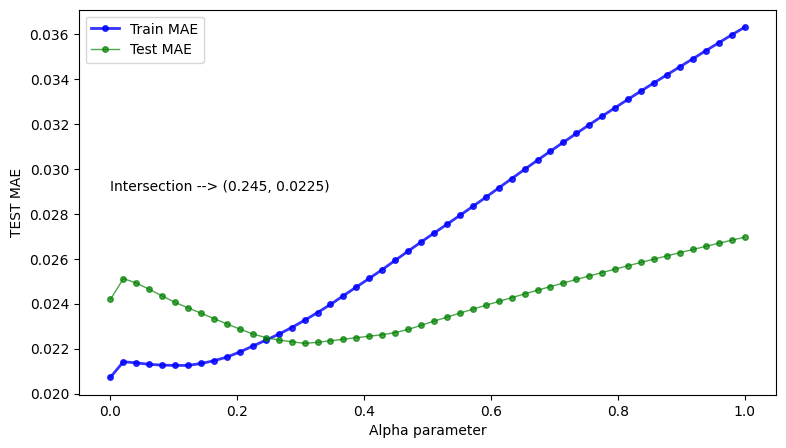

In [11]:
mae_intersection_idx = np.argmin(abs(np.array(train_mae) - np.array(test_mae)))
alpha_at_idx = round(np.linspace(0.0001, 1, 50)[mae_intersection_idx], 4)
mae_at_idx = round(test_mae[mae_intersection_idx], 4)
y_position = max(train_mae)*0.8


plt.figure(figsize = (9,5))

plt.plot(np.linspace(0.0001, 1, 50), train_mae, color='blue', marker='o', linestyle='-', linewidth=2, markersize=4, alpha = .8,
         label = 'Train MAE')
plt.plot(np.linspace(0.0001, 1, 50), test_mae, color='green', marker='o', linestyle='-', linewidth=1, markersize=4, alpha = .7,
         label = 'Test MAE')
plt.legend()
plt.xlabel('Alpha parameter')
plt.ylabel('TEST MAE')
plt.text(0, y_position, f'Intersection --> ({alpha_at_idx}, {mae_at_idx})');

In [12]:
stack = Ridge(alpha =0.245)

x_train, x_test, Y_train, Y_test = train_test_split(dataframe, stack_target, random_state = 6, test_size = .25)

TRAINING DATASET
MAE:  2.24 %
R2_SCORE:  0.9079820406744281
----------------------------
TEST DATASET
MAE:  2.25 %
R2_SCORE:  0.793048286105887
----------------------------


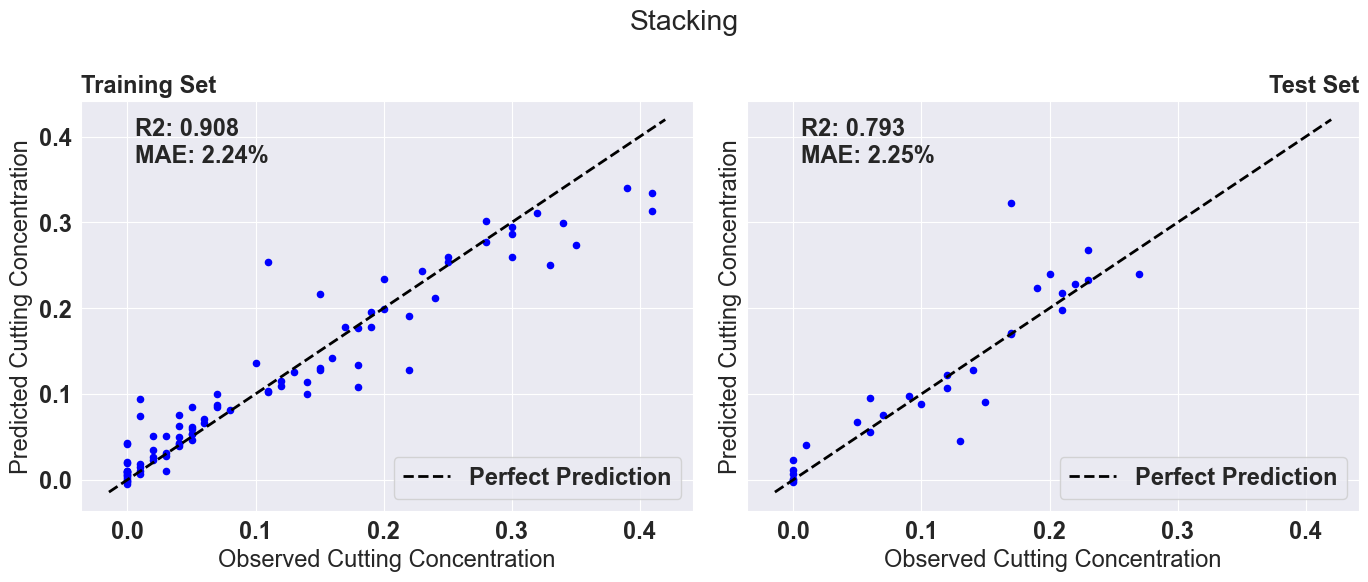

In [13]:
model_report(stack, x_train, Y_train, x_test, Y_test, model_type = 'Stacking')